In [1]:
from __future__ import division
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os 

from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn.functional as fun
import torch.nn as nn 
import torch.utils.data
from torchvision import transforms
from torchvision.datasets import MNIST

/home/cyy/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# !pip install torchsummary

In [3]:
from tensorflow import keras

2022-05-27 09:20:26.338601: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-27 09:20:26.339626: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Preprocess data

In [4]:
# train_df = pd.read_csv('../input/digit-recognizer/train.csv')
# #display(train_df.head())

# test_df = pd.read_csv('../input/digit-recognizer/test.csv')


# y = torch.tensor(train_df.label.values)
# x = torch.tensor(train_df.iloc[:,1:].values)

(x_tr, y_tr), (x_ts, y_ts) = keras.datasets.mnist.load_data()
# x_tr, x_ts, y_tr, y_ts = train_test_split(x,y, test_size = 0.1, random_state=42)


print(f'Train size: {len(y_tr)} \nTest size: {len(y_ts)}')

Train size: 60000 
Test size: 10000


In [5]:
x_tr = x_tr[0:1000]
x_ts = x_ts[0:300]
y_tr = y_tr[0:1000]
y_ts = y_ts[0:300]
print(f'Train size: {len(x_tr)} \nTest size: {len(x_ts)}')

Train size: 1000 
Test size: 300


In [6]:
# conv2d
x_tr = x_tr.reshape(-1, 1, 28, 28)
x_ts = x_ts.reshape(-1, 1, 28, 28)

In [7]:
# plt.figure(1)
# plt.subplot(221)
# plt.imshow(x_tr[4][:,:])

# plt.subplot(222)
# plt.imshow(x_tr[1][:,:])

# plt.subplot(223)
# plt.imshow(x_tr[2][:,:])

# plt.subplot(224)
# plt.imshow(x_tr[3][:,:])
# plt.show()

In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels, transform = None):
        'Initialization'
        self.labels = labels
        self.inp_feats = inputs
        self.transform = transform
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select/Load sample data and get label
        X = torch.Tensor(list(self.inp_feats[index]))
        # print(X.type())
        # X = self.inp_feats[index] #.type('torch.FloatTensor')
        X *= 1/255.0
        y = self.labels[index]
        
        if self.transform is not None:
            X = self.transform(X)

        return X, y

In [9]:
# Parameters
params = {'batch_size': 16,
          'shuffle': True,
          'num_workers': 0}

training_set = Dataset(x_tr, y_tr)
train_gen = torch.utils.data.DataLoader(training_set, **params, drop_last=True)

testing_set = Dataset(x_ts, y_ts)
test_gen = torch.utils.data.DataLoader(testing_set, **params, drop_last=True)

In [10]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [11]:
# define cuda device: 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Vanilla Variational Autoencoder (VAE):

In [12]:
' construct VAE architecture '

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.latent_dim = 3
        
        self.con = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding = 1),
            # nn.BatchNorm2d(32*16*28*28),  # 16 batch size
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding = 1),
            nn.ReLU(),
            
        )
        
        self.dense = nn.Linear(64*14*14, self.latent_dim*2)
       
       
        # self.decoder = nn.Sequential(
        #     nn.Linear(self.latent_dim, 28*28),
        #     nn.ReLU(),
        #     nn.Conv2d(self.latent_dim, 32, 3, padding = 1),
        #     # nn.BatchNorm2d(32*16*28*28),  # 16 batch size
        #     nn.ReLU(),
        #     nn.Conv2d(32, 64, 3, stride = 2, padding = 1),
        #     nn.ReLU(),
        #     nn.Conv2d(64, 64, 3, padding = 1),
        #     nn.ReLU(),
        #     nn.Conv2d(64, 64, 3, padding = 1),
        #     nn.ReLU(),
            
        # )
        # self.encoder = nn.Sequential(
        #     nn.Linear(784, width**2),
        #     nn.BatchNorm1d(width**2),
        #     nn.ReLU(),
        #     nn.Linear(width**2, width**2),
        #     nn.BatchNorm1d(width**2),
        #     nn.ReLU(),
        #     nn.Linear(width**2, width**2),
        #     nn.BatchNorm1d(width**2),
        #     nn.ReLU(),
        #     nn.Linear(width**2, self.latent_dim*2),
        #     nn.BatchNorm1d(self.latent_dim*2)
        # )
        
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, width**2),
            nn.BatchNorm1d(width**2),
            nn.ReLU(),
            nn.Linear(width**2, width**2),
            nn.BatchNorm1d(width**2),
            nn.ReLU(),
            nn.Linear(width**2, 784),
            nn.Sigmoid(),
    
        )
        
        
    def reparam_trick(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def forward(self, x):
        x = self.con(x)
        x = torch.flatten(x, start_dim = 1)
        mu_logvar = self.dense(x).view(-1, 2, self.latent_dim)
        # mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, self.latent_dim)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparam_trick(mu, logvar)
        return self.decoder(z), z, mu, logvar
        
width = 25
# initialize the NN     
model = VAE().to(device)
#print(model)
        
from torchsummary import summary
summary(model, (1, 28, 28))
# summary(model, (1, 28*28))
        
        

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
              ReLU-4           [-1, 64, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          36,928
              ReLU-6           [-1, 64, 14, 14]               0
            Conv2d-7           [-1, 64, 14, 14]          36,928
              ReLU-8           [-1, 64, 14, 14]               0
            Linear-9                    [-1, 6]          75,270
           Linear-10                  [-1, 625]           2,500
      BatchNorm1d-11                  [-1, 625]           1,250
             ReLU-12                  [-1, 625]               0
           Linear-13                  [-1, 625]         391,250
      BatchNorm1d-14                  [

In [13]:
lrate = 0.000100031312
optimizer = torch.optim.Adam(
            model.parameters(),
            lr = lrate)


In [14]:
def VAE_loss(x_tilde, x, mu, logvar, beta):
    BCE = fun.binary_cross_entropy(x_tilde, x.view(-1, 784), reduction = 'sum')
    KL = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    return BCE + beta * KL 
    

#### Train model

In [15]:
def train_model(beta, epochs, model):
    dic = dict(latent_space = list(), mu_list=list(), logsig2_list=list(), y=list())
    for epoch in range(0, epochs + 1):
        # ========= TRAINING =========
        if epoch > 0: 
            model.train()
            train_loss = 0
            for X, _ in train_gen:
                X = X.to(device)
                # forward pass ...
                x_tilde, z, mu, logvar = model(X)
                loss = VAE_loss(x_tilde, X, mu, logvar, beta)
                train_loss += loss.item()
                # backward pass ...
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            # log ...
            print(f'----> Epoch: {epoch} Average loss: {train_loss / len(train_gen.dataset):.4f}')

        # ========= TESTING ========= 

        z_list, means, logvars , labels = list(), list(), list(), list()
        with torch.no_grad():
            model.eval()
            test_loss = 0
            for X, Y in test_gen:
                X = X.to(device)
                # forward ...
                x_tilde, z, mu, logvar = model(X)
                test_loss += VAE_loss(x_tilde, X, mu, logvar, beta).item()
                # log ...
                z_list.append(z.detach())
                means.append(mu.detach())
                logvars.append(logvar.detach())
                labels.append(Y.detach())
        # log ...
        dic['latent_space'].append(torch.cat(z_list))
        dic['mu_list'].append(torch.cat(means))
        dic['logsig2_list'].append(torch.cat(logvars))
        dic['y'].append(torch.cat(labels))
        test_loss /= len(test_gen.dataset)
        print(f'----> Test set loss: {test_loss:.4f}')
    return dic
    
beta = 1
epochs = 100
dic = train_model(beta, epochs, model)

/tmp/ipykernel_481/3341088660.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  X = torch.Tensor(list(self.inp_feats[index]))


----> Test set loss: 520.6145
----> Epoch: 1 Average loss: 398.1596
----> Test set loss: 246.7579
----> Epoch: 2 Average loss: 263.1163
----> Test set loss: 207.1982
----> Epoch: 3 Average loss: 229.3045
----> Test set loss: 202.6430
----> Epoch: 4 Average loss: 215.3916
----> Test set loss: 197.0421
----> Epoch: 5 Average loss: 197.6313
----> Test set loss: 183.0781
----> Epoch: 6 Average loss: 186.6347
----> Test set loss: 177.4505
----> Epoch: 7 Average loss: 180.9046
----> Test set loss: 172.1458
----> Epoch: 8 Average loss: 177.2256
----> Test set loss: 168.5173
----> Epoch: 9 Average loss: 172.7763
----> Test set loss: 165.1715
----> Epoch: 10 Average loss: 171.0975
----> Test set loss: 161.6910
----> Epoch: 11 Average loss: 167.8876
----> Test set loss: 158.3247
----> Epoch: 12 Average loss: 166.7300
----> Test set loss: 157.8806
----> Epoch: 13 Average loss: 165.2902
----> Test set loss: 157.2418
----> Epoch: 14 Average loss: 164.4176
----> Test set loss: 156.9730
----> Epoch: 

#### Plot latent space 
with original data in the latent space

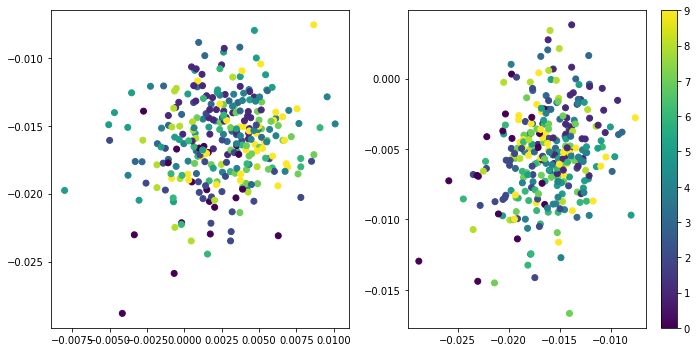

In [16]:
z_arr = dic['latent_space'][0].cpu().numpy()
y_arr = dic['y'][0].cpu().numpy()
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.scatter(z_arr[:,0], z_arr[:,1], c = y_arr)
plt.subplot(1,2,2)
plt.scatter(z_arr[:,1], z_arr[:,2], c = y_arr)
plt.colorbar()
plt.tight_layout()


In [20]:
y_arr

array([2, 9, 1, 0, 6, 9, 4, 1, 3, 7, 3, 5, 8, 1, 7, 5, 2, 1, 2, 4, 0, 4,
       7, 6, 5, 1, 8, 7, 5, 4, 5, 6, 3, 4, 1, 7, 1, 9, 7, 5, 4, 9, 1, 1,
       4, 5, 3, 3, 9, 9, 4, 1, 1, 1, 7, 5, 6, 0, 5, 6, 8, 8, 6, 0, 1, 6,
       7, 3, 8, 8, 1, 3, 0, 4, 7, 1, 6, 5, 8, 6, 3, 1, 1, 7, 7, 7, 7, 7,
       3, 9, 0, 4, 0, 1, 4, 5, 3, 7, 5, 8, 9, 7, 0, 3, 1, 7, 8, 7, 3, 7,
       4, 8, 5, 3, 1, 9, 4, 0, 2, 1, 9, 2, 3, 2, 0, 2, 9, 6, 1, 6, 3, 6,
       2, 2, 9, 2, 4, 4, 4, 2, 7, 0, 7, 9, 8, 4, 2, 4, 9, 8, 9, 7, 7, 4,
       1, 5, 3, 4, 1, 5, 1, 1, 4, 0, 2, 4, 7, 9, 3, 1, 7, 1, 1, 5, 9, 6,
       4, 3, 7, 9, 9, 5, 6, 8, 2, 8, 4, 4, 1, 2, 2, 6, 1, 2, 9, 5, 5, 9,
       9, 6, 2, 7, 7, 2, 2, 4, 2, 1, 6, 7, 5, 8, 7, 7, 1, 5, 9, 2, 6, 9,
       1, 2, 2, 5, 4, 9, 9, 2, 4, 4, 1, 0, 9, 1, 8, 2, 2, 9, 0, 4, 8, 0,
       8, 6, 7, 5, 2, 5, 4, 0, 9, 7, 9, 1, 3, 6, 9, 9, 4, 5, 6, 5, 1, 5,
       5, 2, 7, 9, 9, 5, 8, 2, 3, 3, 4, 1, 3, 0, 2, 0, 6, 4, 0, 0, 6, 1,
       4, 4], dtype=uint8)

Using PCA for plots

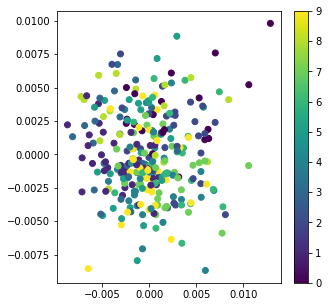

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(z_arr)
plt.figure(figsize = (5,5))
plt.scatter(principalComponents[:,0], principalComponents[:,1], c = y_arr)
plt.colorbar()


The above latent space did not do a great job in disentangling the mnist digits; however, this should ideally be fixed by increasing the latent space dimension. For example, we expand the dimension size from 3 to width parameter, albeit we lose the ability to visualize it. If you do plan to expand the latent space dimension from 3 to width parameter, you can then implement t-SNE to map the latent space to a lower dimension so that you potentially visualize distinct MNIST digit clusters.

## Beta Variational Autoencoder

Here we introduce the $\beta$-VAE, where $\beta$>1 restricts the reconstruction accuracy and increases the degree of disentanglement of learn features. 

In [18]:
# all we need to do now is call the VAE model and define beta > 1 
width = 25
# initialize the NN     
model = VAE().to(device)
print(model)
        
from torchsummary import summary
summary(model, (1,28*28), 1)

beta = 3 # beta becomes an additional hyperparameter
epochs = 100

VAE(
  (con): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (dense): Linear(in_features=12544, out_features=6, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=625, bias=True)
    (1): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=625, out_features=625, bias=True)
    (4): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=625, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[1, 2, 1, 784] to have 1 channels, but got 2 channels instead

#### train $\beta$-VAE

In [ ]:
dic = train_model(beta, epochs, model)

----> Test set loss: 521.6157
----> Epoch: 1 Average loss: 560.9039
----> Test set loss: 533.9483
----> Epoch: 2 Average loss: 560.8438
----> Test set loss: 534.4027
----> Epoch: 3 Average loss: 560.7358
----> Test set loss: 534.8433
----> Epoch: 4 Average loss: 560.6623
----> Test set loss: 535.1098
----> Epoch: 5 Average loss: 560.7757
----> Test set loss: 534.5873
----> Epoch: 6 Average loss: 560.7939
----> Test set loss: 534.9136
----> Epoch: 7 Average loss: 560.7215
----> Test set loss: 534.9665
----> Epoch: 8 Average loss: 560.9075
----> Test set loss: 535.2225
----> Epoch: 9 Average loss: 560.7714
----> Test set loss: 533.7697
----> Epoch: 10 Average loss: 560.8254
----> Test set loss: 535.9485
----> Epoch: 11 Average loss: 560.8687
----> Test set loss: 534.7958
----> Epoch: 12 Average loss: 560.8911
----> Test set loss: 534.6924
----> Epoch: 13 Average loss: 560.8131
----> Test set loss: 534.4945
----> Epoch: 14 Average loss: 560.8423
----> Test set loss: 533.9942
----> Epoch: 

KeyboardInterrupt: 

#### plot latent space

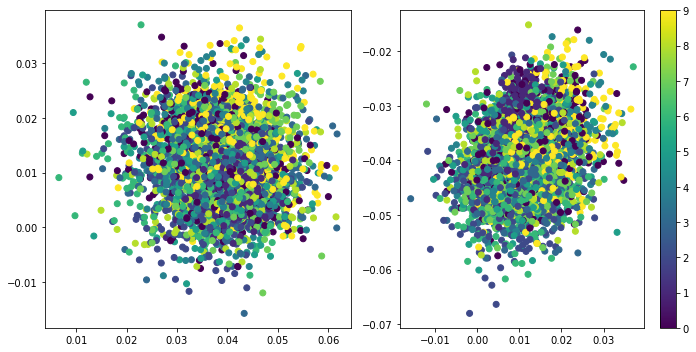

In [ ]:
z_arr = dic['latent_space'][0].cpu().numpy()
y_arr = dic['y'][0].cpu().numpy()
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.scatter(z_arr[:,0], z_arr[:,1], c = y_arr)
plt.subplot(1,2,2)
plt.scatter(z_arr[:,1], z_arr[:,2], c = y_arr)
plt.colorbar()
plt.tight_layout()


## Ref:

Overall, the workflow was adapted from Alfredo Canziani work at https://atcold.github.io/pytorch-Deep-Learning/ with changes to the preprocessing step, specific architectures details, and model extention by including $\beta$-VAE. 